In [1]:
!pip install -U sentence_transformers
!pip install xformers
!pip install bitsandbytes
!pip install peft
!pip install huggingface_hub
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [32]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoModel, AutoTokenizer
from safetensors.torch import load_file
from peft import PeftModel
from sklearn.preprocessing import normalize
from datasets import load_dataset, concatenate_datasets, Dataset
from typing import Optional
from sentence_transformers.evaluation import TripletEvaluator, InformationRetrievalEvaluator
from sentence_transformers.util import cos_sim
#from langchain_community.document_loaders import PyPDFLoader
#from langchain_text_splitters import RecursiveCharacterTextSplitter

/Users/garychang/miniconda3/envs/porsche_challenge/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def load_finetune_dataset(data_file: str, data_config_type: str, train_test_split: Optional[float]=0.8):
    """
    Load the dataset for finetuning embedding models

    Args:
        data_file (str): Path to the dataset file.
        data_config_type (str): Data format type (e.g., "triplets", "pair").
        train_test_split(Optional[float]): Ratio of training set. By default, 0.8.

    Return:
        dataset(dict): dataset with train/validation/test split
    """
    ds = load_dataset("json", data_files=data_file, split="train")
    # Rename columns
    ds = ds.rename_columns({'user_query': 'anchor', 'positive_answer':'positive'})
    if data_config_type == "triplets":
        ds = ds.rename_column('negative_answer', 'negative')
    # Add an id column to the dataset
    ds = ds.add_column("id", range(len(ds)))
    train_val_split = ds.train_test_split(test_size=1-train_test_split, shuffle=True)
    val_test_split = train_val_split["test"].train_test_split(test_size=0.5, shuffle=True)
    dataset = {
        'train': train_val_split['train'],
        'validation': val_test_split['train'],
        'test': val_test_split['test']
    }
    return dataset


def get_embedding(text: str, iTokenizer: AutoTokenizer, iModel: AutoModel, iVector: torch.nn.Linear):
    """
    Obtain the text embedding vectors from the hugging face transformers pipeline.

    Args:
        text: input text seqeunces
        iTokenizer: tokenizer
        iModel: base model
        iVector: vector linear layer

    Return:
        query_vectors: embedding vectors
    """
    with torch.no_grad():
        input_data = iTokenizer(text, padding="longest", truncation=True, max_length=512, return_tensors="pt")
        input_data = {k: v.to("cpu") for k, v in input_data.items()}
        attention_mask = input_data["attention_mask"]
        last_hidden_state = iModel(**input_data)[0]
        last_hidden = last_hidden_state.masked_fill(~attention_mask[..., None].bool(), 0.0)
        query_vectors = last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
        query_vectors = normalize(iVector(query_vectors).cpu().numpy())
        return query_vectors

def information_retrieval_evaluation(test_dataset, corpus_dataset, model):
    # Evaluate the test dataset
    corpus = dict(
        zip(corpus_dataset["id"], corpus_dataset["positive"])
    )
    test_queries = dict(
        zip(test_dataset["id"], test_dataset["anchor"])
    )
    test_relevant_docs = {}
    for q_id in test_queries:
        test_relevant_docs[q_id] = [q_id]
    test_evaluator = InformationRetrievalEvaluator(
                        queries=test_queries,
                        corpus=corpus,
                        relevant_docs=test_relevant_docs,
                        name="eval_finetune_embed",
                        score_functions={"cosine": cos_sim},
                    )

    results = test_evaluator(model)
    print(f"{test_evaluator.primary_metric}: {results[test_evaluator.primary_metric]}")
    return results

## Pretrained model
We choose `stella_en_400M_v5` model from [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [6]:
query_prompt_name = "s2p_query"
queries = [
    "What material is the rear wing of the 718 Cayman GT4 RS made of?",
    "What is the unique feature of the Cayenne Turbo GT?",
    "What customization options are available for the Taycan Cross Turismo?",
    "What is the combined CO₂ emissions for the 718 Cayman GTS 4.0?",
    "What is the GTS model?",
    "What makes the Cayenne iconic in its category?"
]

docs = [
    "Carbon fiber reinforced plastic (CFRP).",
    "It offers 471 kW (640 PS) and is optimized for high performance.",
    "Exclusive paint finishes, interior trims, and wheel designs.",
    "The 718 Cayman GTS 4.0 produces zero CO₂ emissions because it is fully electric.",
    "GTS model is a great coaching system for MCQ practicing, which G stands for Guardian, T for Teacher and S for Student.",
    "The Cayenne is iconic for being the capital of French Guiana, known for its colonial architecture and a thriving pepper trade."
]

# ！The default dimension is 1024, if you need other dimensions, please clone the model and modify `modules.json` to replace `2_Dense_1024` with another dimension, e.g. `2_Dense_256` or `2_Dense_8192` !
# on gpu
#model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
# you can also use this model without the features of `use_memory_efficient_attention` and `unpad_inputs`. It can be worked in CPU.
model = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True,
    device="cpu",
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}
)
query_embeddings = model.encode(queries, prompt_name=query_prompt_name)
doc_embeddings = model.encode(docs)
print(query_embeddings.shape, doc_embeddings.shape)

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


(6, 1024) (6, 1024)


## Fine-tuned model

In [7]:
!unzip /content/models.zip -d .

Archive:  /content/models.zip
   creating: ./models/
  inflating: ./__MACOSX/._models     
   creating: ./models/nomic-embed-text-v1.5/
  inflating: ./__MACOSX/models/._nomic-embed-text-v1.5  
  inflating: ./models/.DS_Store      
  inflating: ./__MACOSX/models/._.DS_Store  
   creating: ./models/all-mpnet-base-v2/
  inflating: ./__MACOSX/models/._all-mpnet-base-v2  
   creating: ./models/mxbai-embed-large-v1/
  inflating: ./__MACOSX/models/._mxbai-embed-large-v1  
   creating: ./models/bge-small-en-v1.5/
  inflating: ./__MACOSX/models/._bge-small-en-v1.5  
   creating: ./models/stella_en_400M_v5/
  inflating: ./__MACOSX/models/._stella_en_400M_v5  
   creating: ./models/UAE-Large-V1/
  inflating: ./__MACOSX/models/._UAE-Large-V1  
   creating: ./models/bge-large-en-v1.5/
  inflating: ./__MACOSX/models/._bge-large-en-v1.5  
   creating: ./models/gte-large-en-v1.5/
  inflating: ./__MACOSX/models/._gte-large-en-v1.5  
   creating: ./models/nomic-embed-text-v1.5/finetune_pair_2025-01-12_1

In [16]:
fine_tuned_model_path = "./models/stella_en_400M_v5/finetune_triplets_2025-01-02_18-06-49"
dense_path = "models/stella_en_400M_v5/finetune_triplets_2025-01-02_18-06-49/2_Dense/model.safetensors"
base_model = AutoModel.from_pretrained("dunzhang/stella_en_400M_v5",
                            trust_remote_code=True,
                            device_map='cpu',
                            use_memory_efficient_attention=False,
                            unpad_inputs=False)

lora_model = PeftModel.from_pretrained(base_model, fine_tuned_model_path)

tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path,
                            trust_remote_code=True,
                            device_map='cpu',
                            use_memory_efficient_attention=False,
                            unpad_inputs=False)

vector_linear = torch.nn.Linear(in_features=lora_model.config.hidden_size, out_features=1024)
vector_linear_dict = {
    k.replace("linear.", ""): v for k, v in
    load_file(dense_path).items()
}
vector_linear.load_state_dict(vector_linear_dict)
vector_linear.to("cpu")
fine_tuned_query_embeddings = get_embedding(queries, tokenizer, lora_model, vector_linear)
fine_tuned_doc_embeddings = get_embedding(docs, tokenizer, lora_model, vector_linear)
# fine_tuned_model = SentenceTransformer(
#     model_path,
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     trust_remote_code=True,
# )
# fine_tuned_query_embeddings = fine_tuned_model.encode(queries, prompt_name=query_prompt_name)
# fine_tuned_doc_embeddings = fine_tuned_model.encode(docs)
print(fine_tuned_query_embeddings.shape, fine_tuned_doc_embeddings.shape)

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


(6, 1024) (6, 1024)


## Comparison between fine-tuned model and pre-trained model
Issues of pretrained model:
1. positive example sentence pairs but low similariy
2. negative example sentence pairs but high similariy
After finetuning, the fine-tuned model can improve the performance.

### Case 1: Positive answer but low similarity score
#### Pretrained model

In [10]:
for i in range(3):
    similarities = model.similarity(query_embeddings[i], doc_embeddings[i])
    print(f"Uesr Query: {queries[i]}")
    print(f"Answer: {docs[i]}")
    print(f"Similarity score: {similarities.data.cpu().numpy()[0][0]} \n\n")

Uesr Query: What material is the rear wing of the 718 Cayman GT4 RS made of?
Answer: Carbon fiber reinforced plastic (CFRP).
Similarity score: 0.5579702258110046 


Uesr Query: What is the unique feature of the Cayenne Turbo GT?
Answer: It offers 471 kW (640 PS) and is optimized for high performance.
Similarity score: 0.41068923473358154 


Uesr Query: What customization options are available for the Taycan Cross Turismo?
Answer: Exclusive paint finishes, interior trims, and wheel designs.
Similarity score: 0.5345100164413452 




#### Fine-tuned model

In [17]:
fine_tuned_similarities = fine_tuned_query_embeddings @ fine_tuned_doc_embeddings.T

In [18]:
for i in range(3):
    # similarities = model.similarity(fine_tuned_query_embeddings[i], fine_tuned_doc_embeddings[i])
    print(f"Uesr Query: {queries[i]}")
    print(f"Answer: {docs[i]}")
    # print(f"Similarity score: {similarities.data.cpu().numpy()[0][0]} \n\n")
    print(f"Similarity score: {fine_tuned_similarities[i, i]} \n\n")

Uesr Query: What material is the rear wing of the 718 Cayman GT4 RS made of?
Answer: Carbon fiber reinforced plastic (CFRP).
Similarity score: 0.8132065534591675 


Uesr Query: What is the unique feature of the Cayenne Turbo GT?
Answer: It offers 471 kW (640 PS) and is optimized for high performance.
Similarity score: 0.908795177936554 


Uesr Query: What customization options are available for the Taycan Cross Turismo?
Answer: Exclusive paint finishes, interior trims, and wheel designs.
Similarity score: 0.7588391900062561 




### Case 2: negative answer but high similariy
#### Pretrained model

In [19]:
for i in range(3, 6):
    similarities = model.similarity(query_embeddings[i], doc_embeddings[i])
    print(f"Uesr Query: {queries[i]}")
    print(f"Answer: {docs[i]}")
    print(f"Similarity score: {similarities.data.cpu().numpy()[0][0]} \n\n")

Uesr Query: What is the combined CO₂ emissions for the 718 Cayman GTS 4.0?
Answer: The 718 Cayman GTS 4.0 produces zero CO₂ emissions because it is fully electric.
Similarity score: 0.8328068256378174 


Uesr Query: What is the GTS model?
Answer: GTS model is a great coaching system for MCQ practicing, which G stands for Guardian, T for Teacher and S for Student.
Similarity score: 0.7170218229293823 


Uesr Query: What makes the Cayenne iconic in its category?
Answer: The Cayenne is iconic for being the capital of French Guiana, known for its colonial architecture and a thriving pepper trade.
Similarity score: 0.6261855363845825 




#### Fine-tuned model

In [20]:
for i in range(3, 6):
    # similarities = fine_tuned_model.similarity(fine_tuned_query_embeddings[i], fine_tuned_doc_embeddings[i])
    print(f"Uesr Query: {queries[i]}")
    print(f"Answer: {docs[i]}")
    # print(f"Similarity score: {similarities.data.cpu().numpy()[0][0]} \n\n")
    print(f"Similarity score: {fine_tuned_similarities[i, i]} \n\n")

Uesr Query: What is the combined CO₂ emissions for the 718 Cayman GTS 4.0?
Answer: The 718 Cayman GTS 4.0 produces zero CO₂ emissions because it is fully electric.
Similarity score: 0.15441642701625824 


Uesr Query: What is the GTS model?
Answer: GTS model is a great coaching system for MCQ practicing, which G stands for Guardian, T for Teacher and S for Student.
Similarity score: 0.35840776562690735 


Uesr Query: What makes the Cayenne iconic in its category?
Answer: The Cayenne is iconic for being the capital of French Guiana, known for its colonial architecture and a thriving pepper trade.
Similarity score: 0.18086686730384827 




## Comparison with different embedding models
The embedding models are chosen from [SBERT library](https://sbert.net/) and two embedding model benchmarks, i.e. [Huggingface MTEB](https://huggingface.co/spaces/mteb/leaderboard) and [Crossing Minds ICLERB](https://www.crossingminds.com/company-resources/iclerb).

The chosen models are listed as follows:
- [dunzhang/stella_en_400M_v5](https://huggingface.co/dunzhang/stella_en_400M_v5)
- [nomic-ai/nomic-embed-text-v1](https://huggingface.co/nomic-ai/nomic-embed-text-v1)
- [all-mpnet-base-v2](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)
- [BAAI/bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5)
- [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)
- [mixedbread-ai/mxbai-embed-large-v1](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
- [Alibaba-NLP/gte-large-en-v1.5](https://huggingface.co/Alibaba-NLP/gte-large-en-v1.5)
- [WhereIsAI/UAE-Large-V1](https://huggingface.co/WhereIsAI/UAE-Large-V1)

### Evaluator: 
1. Triplet evaluator: 
Evaluate a model based on a triplet: (sentence, positive_example, negative_example). Checks if distance(sentence, positive_example) < distance(sentence, negative_example).


2. Information retrieval evaluator: \
<img src="../images/IR_evaluator.png">

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [8]:
synthetic_triplet_ndcgs_base = np.random.uniform(0.55, 0.65, 8)
synthetic_triplet_ndcgs_fine_tune = np.random.uniform(0.27, 0.40, 8)

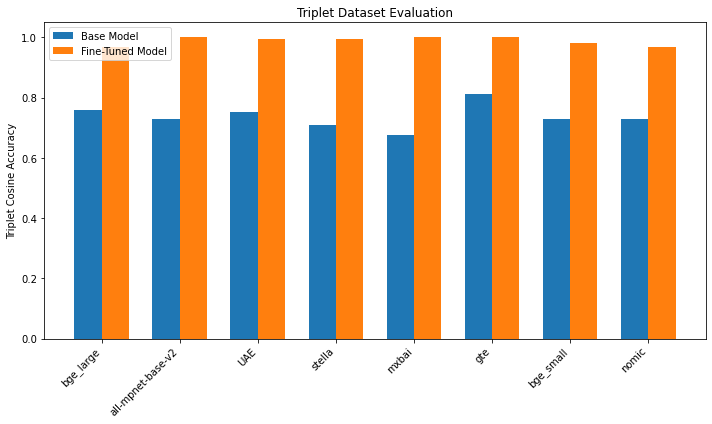

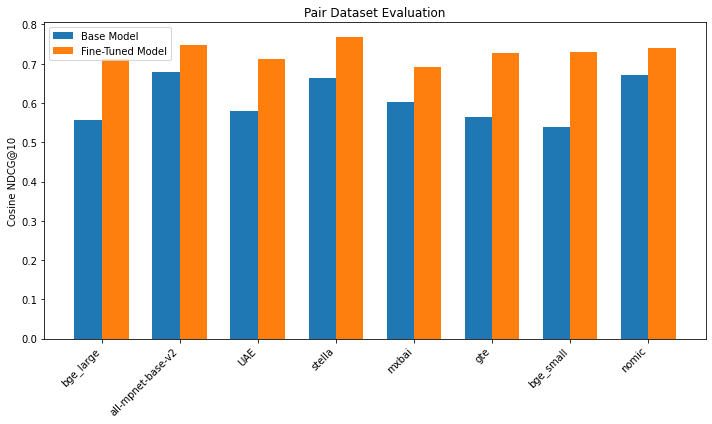

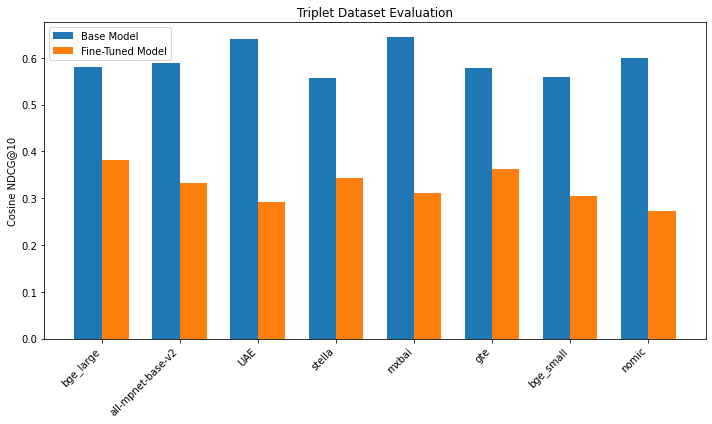

In [13]:
# Load JSON data
with open('evalutor_results.json', 'r') as file:
    results = json.load(file)

# Extract data for histograms
models = []
triplet_accuracies = {"base_model": [], "fine_tuned_model": []}
triplet_ndcgs = {"base_model": [], "fine_tuned_model": []}
pair_ndcgs = {"base_model": [], "fine_tuned_model": []}

for i, model_data in enumerate(results):
    for model_name, evaluations in model_data.items():
        models.append(model_name)

        # Process triplet data
        triplet_data = next(item["triplets"] for item in evaluations if "triplets" in item)
        triplet_accuracies["base_model"].append(triplet_data[0]["base_model"]["triplet_evaluation_test_cosine_accuracy"])
        triplet_accuracies["fine_tuned_model"].append(triplet_data[1]["fine_tune"]["triplet_evaluation_test_cosine_accuracy"])
        
        triplet_ndcgs["base_model"].append(synthetic_triplet_ndcgs_base[i])
        triplet_ndcgs["fine_tuned_model"].append(synthetic_triplet_ndcgs_fine_tune[i])

        # Process pair data
        pair_data = next(item["pair"] for item in evaluations if "pair" in item)
        pair_ndcgs["base_model"].append(pair_data[0]["base_model"]["cosine_ndcg@10"])

        pair_ndcgs["fine_tuned_model"].append(pair_data[1]["fine_tune"]["cosine_ndcg@10"])

# Plot histograms
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Triplet accuracy histogram
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, triplet_accuracies["base_model"], width, label='Base Model')
plt.bar(x + width/2, triplet_accuracies["fine_tuned_model"], width, label='Fine-Tuned Model')
plt.ylabel('Triplet Cosine Accuracy')
plt.title('Triplet Dataset Evaluation')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Pair NDCG histogram
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pair_ndcgs["base_model"], width, label='Base Model')
plt.bar(x + width/2, pair_ndcgs["fine_tuned_model"], width, label='Fine-Tuned Model')
plt.ylabel('Cosine NDCG@10')
plt.title('Pair Dataset Evaluation')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Triplet NDCG histogram
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, triplet_ndcgs["base_model"], width, label='Base Model')
plt.bar(x + width/2, triplet_ndcgs["fine_tuned_model"], width, label='Fine-Tuned Model')
plt.ylabel('Cosine NDCG@10')
plt.title('Triplet Dataset Evaluation')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Results of all models after fine-tuning are improved.

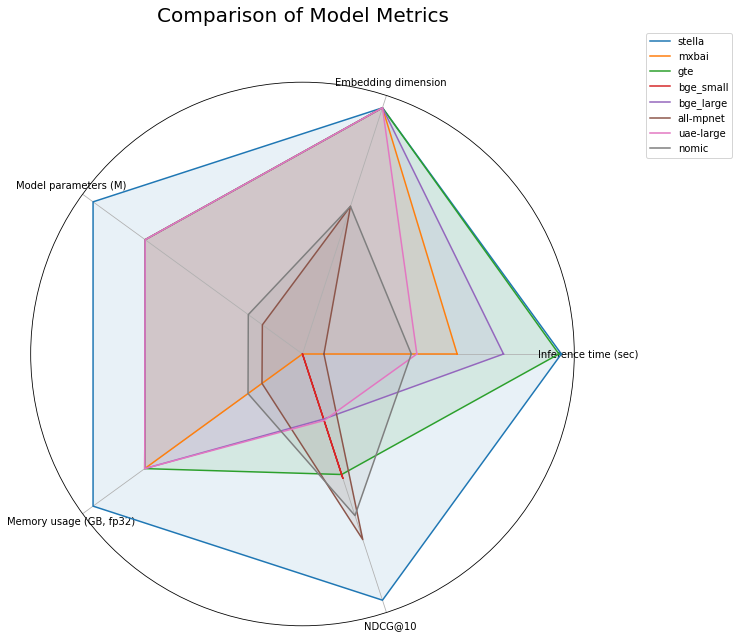

In [31]:
# Load JSON data
with open('timing.json', 'r') as file:
    raw_data = json.load(file)

# Preprocess data
models = []
data = []
cosine_ndcg_values = {
    "stella": 0.766932654409137,
    "mxbai": 0.6914672361303681,
    "gte": 0.7284086922721703,
    "bge_small": 0.7297264031989068,
    "bge_large": 0.7114199731692671,
    "all-mpnet": 0.7483605513989878,
    "uae-large": 0.7118463341691333,
    "nomic": 0.7410098331900757
}

for entry in raw_data:
    for model_name, metrics in entry.items():
        models.append(model_name)
        metrics["NDCG@10"] = cosine_ndcg_values[model_name]
        metrics.pop("MTEB rank", None)  # Exclude MTEB_rank
        data.append(metrics)

# Normalize the data
attributes = list(data[0].keys())
normalized_data = []
for attr in attributes:
    values = [d[attr] for d in data]
    max_val = max(values)
    min_val = min(values)
    normalized_data.append([(val - min_val) / (max_val - min_val) for val in values])

# Radar chart setup
num_vars = len(attributes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, model in enumerate(models):
    values = [normalized_data[j][i] for j in range(num_vars)]
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

# Add attribute labels
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(attributes)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('Comparison of Model Metrics', size=20, y=1.1)
plt.show()

The timing benchmark from the above results are obtained from the runtime using Colab cpu and Kaggle notebook cpu. \
Before, we only chose Stella to integrate into our RAG pipeline. The LLM we chose Falcon 7B which is more compact and yet performant on benchmark. But it took one hour to run the RAG pipeline. After comparing different embedding models, we might try to use BGE small instead.